In [ ]:
# Set local paths here

system_path = '/content/drive/MyDrive/Colab Notebooks/INM706_CW'

In [ ]:
!pip install transformers
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append(system_path)

In [ ]:
import torch
import dataset_flickr7k
import helper_classes as helper
import nltk
from torch.utils.data import Dataset, DataLoader
nltk.download('punkt')

import importlib 
import model_attn_2 as model_attn
importlib.reload(model_attn)

import torch.nn as nn
import matplotlib.pyplot as plt 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# dataset
data_args = {'stage': 'test',
            'ds_path' : system_path, 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}

test_data = dataset_flickr7k.Flickr7kData(**data_args)
pad_idx = test_data.vocabulary.str_to_idx["<PAD>"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

length = 1000
stage:  test
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/test
Initialized 7736 words in vocabulary


device(type='cuda')

# Encoder Decoder Attention Tests

In [ ]:
# Load model for inference 
embed_size = 256
hidden_size = 512
attn_dim = 256 
num_layers = 1
vocab_size = len(test_data.vocabulary)

attention_test_model = model_attn.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, attn_dim).to(device)
helper.load_model(attention_test_model, "attention_model.pth")

Initialized Encoder!
Initialized Decoder!
Loaded from model attention_model.pth!


## BLEU Score

In [ ]:
test_loader = DataLoader(
        dataset=test_data,
        batch_size=  1,
        shuffle=True,
    )

### Single BLEU Test

In [ ]:
# Test bleu score for one sample
w1=(1, 0, 0, 0)
w2=(0, 1, 0, 0)
w3=(0, 0, 1, 0)
w4=(0, 0, 0, 1)

n_weights = [w1, w2, w3, w4]

score_total = [0,0,0,0]

attention_test_model.eval()

idx, X, y= next(iter(test_loader))
X = X.to(device)
features = attention_test_model.encoder(X)

captions = test_data.get_all_captions(idx.item())
print("Expected:")

tokenized = []
for c in captions:
    print(c)
    tokenized.append(nltk.tokenize.word_tokenize(c.lower()))
print()

predicted, _ = attention_test_model.generate_caption(features, test_data.vocabulary)
# Remove EOS
predicted = predicted[:-1]

print(f'Predicted: {predicted}')

b4 = helper.get_bleu_score(tokenized, predicted)

for idx, w in enumerate(n_weights):
        score = helper.get_bleu_score(tokenized, predicted, weights=w)
        score_total[idx] += score

for idx, a in enumerate(score_total):
   print(f"{idx+1}-gram Bleu Score Average: {a}") 
print(b4)


Expected:
Several dogs running a race on a dirt track while wearing numbers .
Muzzled greyhounds are racing on the track .
Dogs race each other on a muddy track .
Race dogs midair while they run .
Greyhounds race on a track .

Predicted: ['a', 'dog', 'is', 'running', 'on', 'a', 'track', '.']
1-gram Bleu Score Average: 0.75
2-gram Bleu Score Average: 0.42857142857142855
3-gram Bleu Score Average: 0.3333333333333333
4-gram Bleu Score Average: 0.2
0.38260294162784475


### BLEU on test set

In [ ]:
# Test BLEU score

# Set trackers for each N-gram score
score_total = [0,0,0,0]
bleu4 = 0

# set weight variables
w1=(1, 0, 0, 0)
w2=(0, 1, 0, 0)
w3=(0, 0, 1, 0)
w4=(0, 0, 0, 1)

n_weights = [w1, w2, w3, w4]

for batch_num, (idx, X, y) in enumerate(test_loader):
    X = X.to(device)
    features = attention_test_model.encoder(X)

    captions = test_data.get_all_captions(idx.item())
    tokenized = []
    for c in captions:
        tokenized.append(nltk.tokenize.word_tokenize(c.lower()))

    predicted, _ = attention_test_model.generate_caption(features, test_data.vocabulary)
    # Remove EOS
    predicted = predicted[:-1]

    for idx, w in enumerate(n_weights):
        score = helper.get_bleu_score(tokenized, predicted, weights=w)
        score_total[idx] += score
        

    b4 = helper.get_bleu_score(tokenized, predicted)
    bleu4 +=b4

average = []

for score in score_total:
    average.append(score/(batch_num+1))

for idx, a in enumerate(average):
   print(f"{idx+1}-gram Bleu Score Average: {a}") 

print(f'BLEU-4: {bleu4/(batch_num+1)}')

1-gram Bleu Score Average: 0.5933626839809986
2-gram Bleu Score Average: 0.24939482615167544
3-gram Bleu Score Average: 0.11180812560345116
4-gram Bleu Score Average: 0.056826344407502984
BLEU-4: 0.14643215921726443


## Sample captions

Captions: 
A older man in a orange wrap looks into the camera on the sidewalk of a city .
Old monk in orange with tattoos on his chest standing on a city street .
Older Asian man , wearing orange robes in urban area .
A monk in a red shawl looks at the camera
A monk walks down a city street .

Predicted:  ['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'building', '.']
BLEU-4: 0.19674979811155635


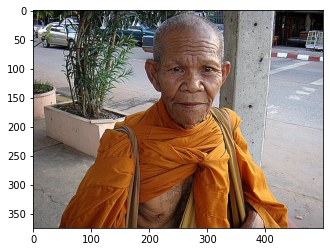

Captions: 
Two girls enjoy themselves whilst wind blows through their hair .
Two girls with long hair jumping on a trampoline .
Two little girls are playing on a trampoline .
Two little blond girls twirl their hair .
Two blond girls are playing together .

Predicted:  ['a', 'little', 'girl', 'in', 'a', 'pink', 'shirt', 'is', 'sitting', 'on', 'a', 'chair', '.']
BLEU-4: 0.021972813874997166


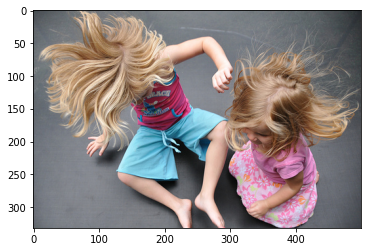

Captions: 
A black dog is standing on a street while a group of cars and a truck are parked in the background .
A black Dog , in a Alley maybe , He might be lost , and Cold , or Hungry .
A small dog stands in a street with five vehicles in the background .
A small black dog stands in the middle of a street .
A small dog standing in the middle of the street .

Predicted:  ['a', 'man', 'in', 'a', 'black', 'jacket', 'is', 'walking', 'down', 'a', 'street', '.']
BLEU-4: 0.02343404092837612


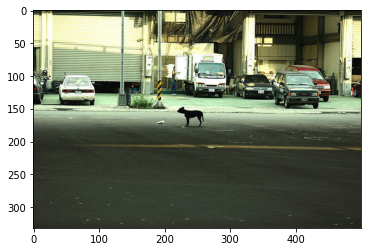

In [ ]:
for _ in range(3):
    idx, X, y= next(iter(test_loader))
    X = X.to(device)
    plt.imshow(test_data.plot_img(idx.item()))
    expected = test_data.get_all_captions(idx.item())

    print("Captions: ")
    tokenized = []
    for e in expected:
        tokenized.append(nltk.tokenize.word_tokenize(c.lower()))
        print(e)

    features = attention_test_model.encoder(X)
    predicted, _ = attention_test_model.generate_caption(features, test_data.vocabulary)
    # Remove EOS
    predicted = predicted[:-1]
    
    print("\nPredicted: ", predicted)
    print(f'BLEU-4: {helper.get_bleu_score(tokenized, predicted)}')
    plt.show()

## Plot Attention

In [ ]:
from torchvision import transforms as transforms
def plot_attention(img, caption, attention_plot):
    untransform = transforms.Compose([
        transforms.Normalize(mean = [ 0., 0., 0. ],
        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
        std = [ 1., 1., 1. ]),
    ])

    img = untransform(img)
    img = img.numpy().transpose((1, 2, 0))
    tmp = img

    fig = plt.figure(figsize=(15, 15))

    caption_length = len(caption)

    for c in range(caption_length):
        temp_att = attention_plot[c].reshape(8,8)
        
        x = caption_length//2

        ax = fig.add_subplot(x,x, c+1)
        ax.set_title(caption[c])
        img = ax.imshow(tmp)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()


Predicted: ['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'sign', '.', '<EOS>']


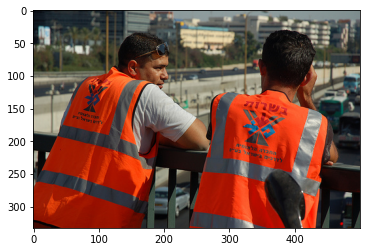

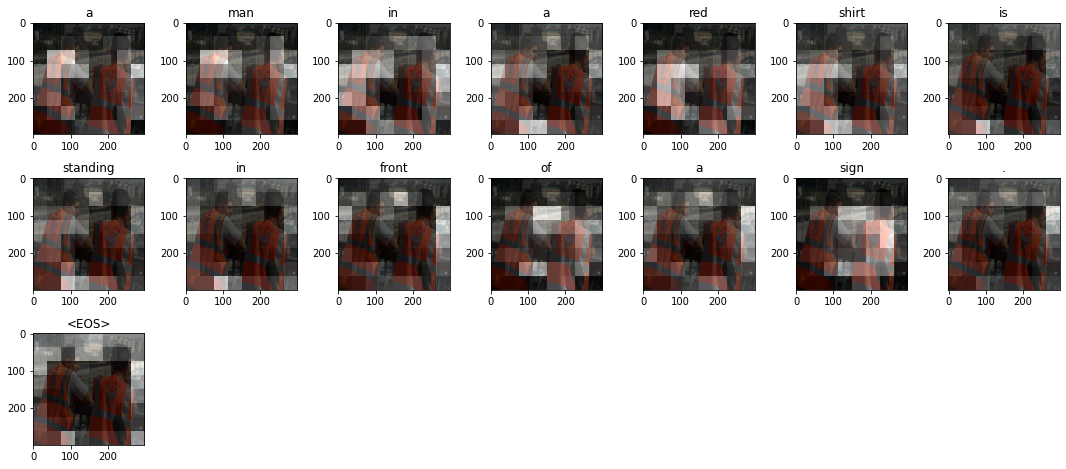

In [ ]:
idx, X, y= next(iter(test_loader))

img = X[0].detach().clone()
img1 = X[0].detach().clone()

X = X.to(device)

features = attention_test_model.encoder(X)

caption, alphas= attention_test_model.generate_caption(features, test_data.vocabulary)
# Remove EOS
cap = caption[:-1]


print(f"Predicted: {caption}")
plt.imshow(test_data.plot_img(idx.item()))
plt.show()

plot_attention(img1, caption, alphas)

## Loss 

In [ ]:
# Set up variables for loss calculation
test_loader_100 = DataLoader(
        dataset=test_data,
        batch_size=  100,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx)
    )

criterion = nn.CrossEntropyLoss(ignore_index=test_data.vocabulary.str_to_idx["<PAD>"])

In [ ]:
batch_loss = 0

for batch_num, (idx, X, y) in enumerate(test_loader_100):
    X = X.to(device)
    y = y.to(device)

    y_train = y.to(device)
    outputs = attention_test_model(X, y_train)
    y_target = y[:, 1:].to(device)
    
    loss = criterion(
        outputs.reshape(-1, outputs.shape[2]), 
        y_target.reshape(-1)
    )
    
    batch_loss += loss.item()

avg_batch_loss = batch_loss/(batch_num+1)

print(f'Average loss: {avg_batch_loss}')

Average loss: 3.008302187919617


# Encoder Decoder (No Attention) Tests

In [ ]:
import model
importlib.reload(model)
embed_size = 256
hidden_size = 256
attn_dim = 256 
num_layers = 1
extract_features = True
vocab_size = len(test_data.vocabulary)

basic_test_model = model.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, extract_features).to(device)
helper.load_model(basic_test_model, "basic_model.pth")

Initialized Encoder!
Initialized Decoder!
Loaded from model basic_model.pth!


## BLEU Score

### Single BLEU Test

In [ ]:
# Test bleu score for one sample
basic_test_model.eval()

idx, X, y= next(iter(test_loader))
X = X.to(device)
features = basic_test_model.encoder(X)

captions = test_data.get_all_captions(idx.item())

tokenized = []
for c in captions:
    tokenized.append(nltk.tokenize.word_tokenize(c.lower()))
print(captions)

predicted = basic_test_model.caption_image(X, test_data.vocabulary, )
print(predicted)

score = helper.get_bleu_score(tokenized, predicted)
print(score)

['Two guys one in a white shirt with glasses and another with an orange blanket covering him it looks as though the man in the orange is getting his haircut .', 'A man with a large mustache watches the barber conduct his work through the mirror that faces him .', "A mirror reflecting a man sitting in a barber 's chair getting his haircut by another man .", "A man is in a barber 's shop getting a haircut .", "A man sits in a barber 's chair ."]
['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'a', 'woman', 'in', 'a', 'white', 'shirt', 'and', 'black', 'pants', 'are', 'standing']
0.18710158230410626


### BLEU on test set

In [ ]:
# Test Bleu score

# Set trackers for each N-gram score
score_total = [0,0,0,0]
bleu4 = 0

# set weight variables
w1=(1, 0, 0, 0)
w2=(0, 1, 0, 0)
w3=(0, 0, 1, 0)
w4=(0, 0, 0, 1)

n_weights = [w1, w2, w3, w4]

for batch_num, (idx, X, y) in enumerate(test_loader):
    X = X.to(device)
    features = basic_test_model.encoder(X)

    captions = test_data.get_all_captions(idx.item())
    
    tokenized = []
    for c in captions:
        tokenized.append(nltk.tokenize.word_tokenize(c.lower()))

    predicted = basic_test_model.caption_image(X, test_data.vocabulary)

    for idx, w in enumerate(n_weights):
        score = helper.get_bleu_score(tokenized, predicted, weights=w)
        score_total[idx] += score

    b4 = helper.get_bleu_score(tokenized, predicted)
    bleu4 +=b4

average = []

for score in score_total:
    average.append(score/(batch_num+1))

for idx, a in enumerate(average):
   print(f"{idx+1}-gram BLEU Score Average: {a}") 
   
print(f'BLEU-4: {bleu4/(batch_num+1)}')

1-gram Bleu Score Average: 0.5175173653929603
2-gram Bleu Score Average: 0.1847476966197751
3-gram Bleu Score Average: 0.07666985993595753
4-gram Bleu Score Average: 0.04101680980309377
BLEU-4: 0.1098454912926903


## Sample Captions

Captions: 
A woman in a blue plaid shirt and white apron cooks food in a pot next to vegetables and rice .
A woman wearing a blue checkered shirt scoops food from a pot .
A person in a blue shirt is serving a meal .
Someone is cooking a meal .
A person is cooking food .

Predicted:  ['a', 'man', 'in', 'a', 'white', 'shirt', 'is', 'sitting', 'on', 'a', 'bench', '.']
BLEU-4: 0.007501256085760326


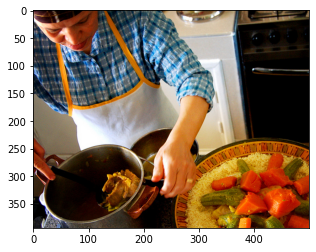

Captions: 
A woman in a red vest jogs down the street in a heavy rain .
A woman wearing a red vest runs a race through the rain .
A woman runner in red is getting drenched in the rain .
A loan runner participates in a race in the rain .
Woman jogging in the rain .

Predicted:  ['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'blue', 'shorts', 'is', 'jumping', 'in', 'the', 'air', '.']
BLEU-4: 0.007816435614790406


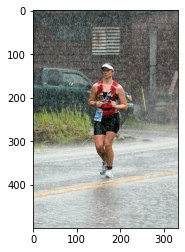

Captions: 
Children in blue shirts do homework around a large table .
Kids in blue shirts are writing at the table .
Nine kids sit at a table , doing homework .
Children in blue shirts drawing pictures .
They are writing while wearing blue .

Predicted:  ['a', 'woman', 'in', 'a', 'white', 'shirt', 'is', 'sitting', 'on', 'a', 'bench', '.']
BLEU-4: 0.0029993746530434483


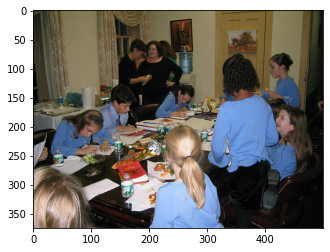

In [ ]:
for _ in range(3):
    idx, X, y= next(iter(test_loader))
    X = X.to(device)
    plt.imshow(test_data.plot_img(idx.item()))
    expected = test_data.get_all_captions(idx.item())

    print("Captions: ")
    for e in expected:
        print(e)

    predicted = basic_test_model.caption_image(X, test_data.vocabulary)
    print("\nPredicted: ", predicted)

    print(f'BLEU-4: {helper.get_bleu_score(expected, predicted)}')
    plt.show()

## Loss

In [ ]:
# Set up variables for loss calculation
test_loader_100 = DataLoader(
        dataset=test_data,
        batch_size=  100,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx, batch_first=False)
    )

criterion = nn.CrossEntropyLoss(ignore_index=test_data.vocabulary.str_to_idx["<PAD>"])

In [ ]:
batch_loss = 0

for batch_num, (idx, X, y) in enumerate(test_loader_100):
    X = X.to(device)
    y = y.to(device)

    outputs = basic_test_model(X, y[:-1])

    loss = criterion(
        outputs.reshape(-1, outputs.shape[2]), y.reshape(-1)
    )

    batch_loss += loss.item()


avg_batch_loss = batch_loss/(batch_num+1)
print(f'Average loss: {avg_batch_loss}')

Average loss: 2.9437172269821166


# Other Tests

Check BLEU scores on training / validation sets

In [ ]:
# dataset
data_args = {'stage': 'train',
            'ds_path' : system_path, 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}

train_data = dataset_flickr7k.Flickr7kData(**data_args)


data_args = {'stage': 'val',
            'ds_path' : system_path, 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}

val_data = dataset_flickr7k.Flickr7kData(**data_args)
pad_idx = val_data.vocabulary.str_to_idx["<PAD>"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

length = 7000
stage:  train
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/train
Initialized 7736 words in vocabulary
length = 2000
stage:  val
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/val
Initialized 7736 words in vocabulary


device(type='cuda')

In [ ]:
train_loader = DataLoader(
        dataset=train_data,
        batch_size=  1,
        shuffle=True,
    )

val_loader = DataLoader(
        dataset=val_data,
        batch_size=  1,
        shuffle=True,
    )

## Attention

### Train Set

In [ ]:
# Test Bleu score - Train

# Set trackers for each N-gram score
score_total = [0,0,0,0]
bleu4 = 0

# set weight variables
w1=(1, 0, 0, 0)
w2=(0, 1, 0, 0)
w3=(0, 0, 1, 0)
w4=(0, 0, 0, 1)

n_weights = [w1, w2, w3, w4]

for batch_num, (idx, X, y) in enumerate(train_loader):
    
    X = X.to(device)
    features = attention_test_model.encoder(X)

    captions = train_data.get_all_captions(idx.item())
    tokenized = []
    for c in captions:
        tokenized.append(nltk.tokenize.word_tokenize(c.lower()))

    predicted, _ = attention_test_model.generate_caption(features, test_data.vocabulary)
    # Remove EOS
    predicted = predicted[:-1]

    for idx, w in enumerate(n_weights):
        score = helper.get_bleu_score(tokenized, predicted, weights=w)
        score_total[idx] += score
        

    b4 = helper.get_bleu_score(tokenized, predicted)
    bleu4 +=b4

average = []

for score in score_total:
    average.append(score/(batch_num+1))

for idx, a in enumerate(average):
   print(f"{idx+1}-gram Bleu Score Average: {a}") 

print(f'BLEU-4: {bleu4/(batch_num+1)}')

1-gram Bleu Score Average: 0.6047138565003443
2-gram Bleu Score Average: 0.2695416203606635
3-gram Bleu Score Average: 0.12791547564278966
4-gram Bleu Score Average: 0.06718809231095553
BLEU-4: 0.1636894355376915


### Validation Set

In [ ]:
# Test Bleu score - Val

# Set trackers for each N-gram score
score_total = [0,0,0,0]
bleu4 = 0

# set weight variables
w1=(1, 0, 0, 0)
w2=(0, 1, 0, 0)
w3=(0, 0, 1, 0)
w4=(0, 0, 0, 1)

n_weights = [w1, w2, w3, w4]

for batch_num, (idx, X, y) in enumerate(val_loader):
    
    X = X.to(device)
    features = attention_test_model.encoder(X)

    captions = val_data.get_all_captions(idx.item())
    tokenized = []
    for c in captions:
        tokenized.append(nltk.tokenize.word_tokenize(c.lower()))

    predicted, _ = attention_test_model.generate_caption(features, test_data.vocabulary)
    # Remove EOS
    predicted = predicted[:-1]

    for idx, w in enumerate(n_weights):
        score = helper.get_bleu_score(tokenized, predicted, weights=w)
        score_total[idx] += score
        

    b4 = helper.get_bleu_score(tokenized, predicted)
    bleu4 +=b4

average = []

for score in score_total:
    average.append(score/(batch_num+1))

for idx, a in enumerate(average):
   print(f"{idx+1}-gram Bleu Score Average: {a}") 

print(f'BLEU-4: {bleu4/(batch_num+1)}')

1-gram Bleu Score Average: 0.5908003694243696
2-gram Bleu Score Average: 0.246467810578222
3-gram Bleu Score Average: 0.11215303715502319
4-gram Bleu Score Average: 0.058126523332310956
BLEU-4: 0.14744184577384126


## Basic

### Train Set

In [ ]:
# Test BLEU score - Train

# Set trackers for each N-gram score
score_total = [0,0,0,0]
bleu4 = 0

# set weight variables
w1=(1, 0, 0, 0)
w2=(0, 1, 0, 0)
w3=(0, 0, 1, 0)
w4=(0, 0, 0, 1)

n_weights = [w1, w2, w3, w4]

for batch_num, (idx, X, y) in enumerate(train_loader):
    X = X.to(device)
    features = basic_test_model.encoder(X)

    captions = train_data.get_all_captions(idx.item())
    tokenized = []
    for c in captions:
        tokenized.append(nltk.tokenize.word_tokenize(c.lower()))

    predicted = basic_test_model.caption_image(X, test_data.vocabulary)

    for idx, w in enumerate(n_weights):
        score = helper.get_bleu_score(tokenized, predicted, weights=w)
        score_total[idx] += score

    b4 = helper.get_bleu_score(tokenized, predicted)
    bleu4 +=b4

average = []

for score in score_total:
    average.append(score/(batch_num+1))

for idx, a in enumerate(average):
   print(f"{idx+1}-gram Bleu Score Average: {a}") 
   
print(f'BLEU-4: {bleu4/(batch_num+1)}')

1-gram Bleu Score Average: 0.5176087393126346
2-gram Bleu Score Average: 0.18978721875483662
3-gram Bleu Score Average: 0.08020585389350739
4-gram Bleu Score Average: 0.041831200447074654
BLEU-4: 0.11282151349864031


### Validation Set

In [ ]:
# Test BLEU score- Val

# Set trackers for each N-gram score
score_total = [0,0,0,0]
bleu4 = 0

# set weight variables
w1=(1, 0, 0, 0)
w2=(0, 1, 0, 0)
w3=(0, 0, 1, 0)
w4=(0, 0, 0, 1)

n_weights = [w1, w2, w3, w4]

for batch_num, (idx, X, y) in enumerate(val_loader):
    X = X.to(device)
    features = basic_test_model.encoder(X)

    captions = val_data.get_all_captions(idx.item())
    tokenized = []
    for c in captions:
        tokenized.append(nltk.tokenize.word_tokenize(c.lower()))

    predicted = basic_test_model.caption_image(X, test_data.vocabulary)

    for idx, w in enumerate(n_weights):
        score = helper.get_bleu_score(tokenized, predicted, weights=w)
        score_total[idx] += score

    b4 = helper.get_bleu_score(tokenized, predicted)
    bleu4 +=b4

average = []

for score in score_total:
    average.append(score/(batch_num+1))

for idx, a in enumerate(average):
   print(f"{idx+1}-gram Bleu Score Average: {a}") 
   
print(f'BLEU-4: {bleu4/(batch_num+1)}')

1-gram Bleu Score Average: 0.5141546055819003
2-gram Bleu Score Average: 0.1870546225164737
3-gram Bleu Score Average: 0.07820669550040181
4-gram Bleu Score Average: 0.04244991911379404
BLEU-4: 0.1112829875483433
